# **Аналих данных термопары промышленного оборудования с экспериментальной установки из датасета SKAB**



In [1]:
#Импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#Считывание датасета присвоение переменной его значение
d = pd.read_csv('skab_valve_1.csv', sep=';')
#Фильтрация
df = pd.DataFrame()
df[['timestamp', 'target', 'anomaly']] = d[['datetime', 'Thermocouple', 'anomaly']]
#Вывод информации
df

,timestamp,target,anomaly
0,2020-03-09 12:34:37,24.9122,0.0
1,2020-03-09 12:34:38,24.9038,0.0
2,2020-03-09 12:34:39,24.9055,0.0
3,2020-03-09 12:34:40,24.9110,0.0
4,2020-03-09 12:34:41,24.9110,0.0
...,...,...,...
1089,2020-03-09 12:54:33,24.8565,0.0
1090,2020-03-09 12:54:34,24.8596,0.0
1091,2020-03-09 12:54:35,24.8600,0.0
1092,2020-03-09 12:54:36,24.8553,0.0


### **Визуализация**

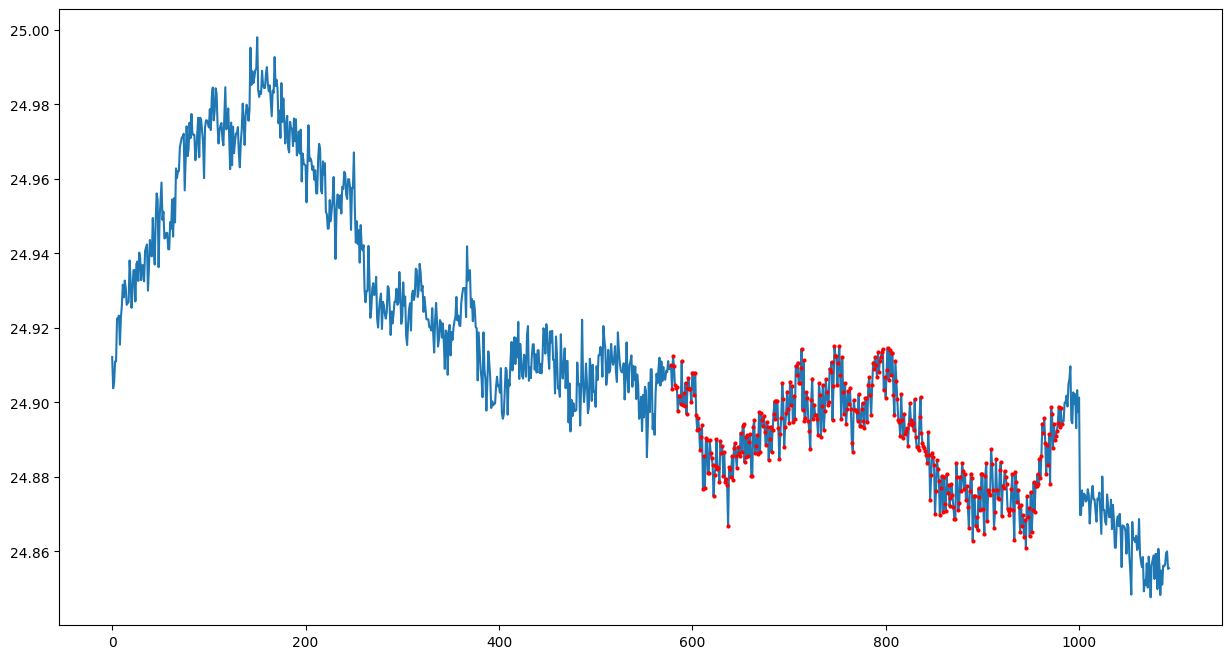

In [47]:
#Визуализация информации
plt.figure(figsize=(15,8))
plt.plot(df['target'])
plt.plot(df.loc[df['anomaly'] == 1, 'target'], "ro", markersize=2)

### **Статистическая эвристика**

In [7]:
from sklearn.metrics import confusion_matrix as cm

### **Фильтрация**

In [9]:
def stats_method(df, variable):
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3 - q1
    inner_fence = 1.5 * iqr
    outer_fence = 3 * iqr

    inner_fence_le = q1 - inner_fence
    inner_fence_ue = q3 + inner_fence

    outer_fence_le = q1 - outer_fence
    outer_fence_ue = q3 + outer_fence

    outliers = []
    for index, x in enumerate(df[variable]):
        if x <= inner_fence_le or x >= inner_fence_ue:
            outliers.append(1)
        else:
            outliers.append(0)
    return outliers

In [10]:
outliers = stats_method(df, "target")
df['outlier'] = outliers

### **Визуализация**

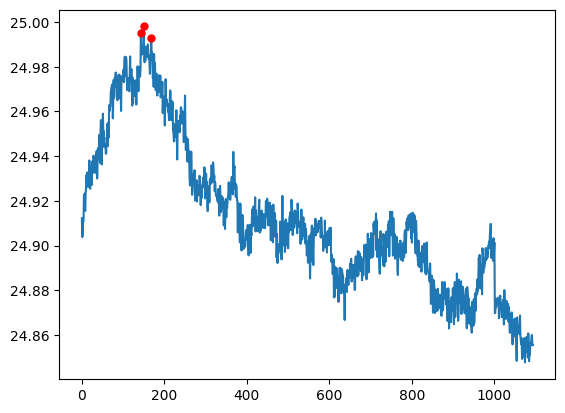

In [11]:
plt.plot(df['target'])
plt.plot(df.loc[df['outlier'] == 1, 'target'], "ro", markersize=5)

### **Confusion matrix**

In [12]:
cm_stat = cm(df['anomaly'], df['outlier'])
cm_stat

array([[686,   3],
       [405,   0]])

Матрица читается следующим образом

[True negative, False positive]

[False negative, True positive]

Модель не угадала ни одной реальной аномалии (True positive), записала 3 нормальные точки в ошибки (False positive)

686 точек модель не записала в ошибки, они ими и не являются (True negative), 405 точек модель не записала в ошибки, хотя они ими являются (False negative)

Результаты не очень хорошие, точность модели (TP/(TP+FP)) = 0

### **Кластеризация**

In [13]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [14]:
df_c = df.drop('outlier', axis=1)
df_c['timestamp'] = pd.to_datetime(df_c['timestamp'])
df_c

,timestamp,target,anomaly
0,2020-03-09 12:34:37,24.9122,0.0
1,2020-03-09 12:34:38,24.9038,0.0
2,2020-03-09 12:34:39,24.9055,0.0
3,2020-03-09 12:34:40,24.9110,0.0
4,2020-03-09 12:34:41,24.9110,0.0
...,...,...,...
1089,2020-03-09 12:54:33,24.8565,0.0
1090,2020-03-09 12:54:34,24.8596,0.0
1091,2020-03-09 12:54:35,24.8600,0.0
1092,2020-03-09 12:54:36,24.8553,0.0


In [15]:
for i in range(1, 4):
    df_c['lag_{}'.format(i)] = df_c['target'].shift(i)

In [16]:
for i in range(1,5):
    df_c['rolling_{}'.format(15*i)] = df_c['target'].rolling(15*i, min_periods=1).mean()

In [17]:
df_c['minute'] = df_c['timestamp'].dt.minute
df_c = (df_c.join(df_c.groupby(['minute'])['target'].mean(),
                  on = ['minute'], rsuffix='_average'))

In [18]:
df_c = df_c.dropna()
df_c

,timestamp,target,anomaly,lag_1,lag_2,lag_3,rolling_15,rolling_30,rolling_45,rolling_60,minute,target_average
3,2020-03-09 12:34:40,24.9110,0.0,24.9055,24.9038,24.9122,24.908125,24.908125,24.908125,24.908125,34,24.923513
4,2020-03-09 12:34:41,24.9110,0.0,24.9110,24.9055,24.9038,24.908700,24.908700,24.908700,24.908700,34,24.923513
5,2020-03-09 12:34:42,24.9225,0.0,24.9110,24.9110,24.9055,24.911000,24.911000,24.911000,24.911000,34,24.923513
6,2020-03-09 12:34:43,24.9225,0.0,24.9225,24.9110,24.9110,24.912643,24.912643,24.912643,24.912643,34,24.923513
7,2020-03-09 12:34:44,24.9233,0.0,24.9225,24.9225,24.9110,24.913975,24.913975,24.913975,24.913975,34,24.923513
...,...,...,...,...,...,...,...,...,...,...,...,...
1089,2020-03-09 12:54:33,24.8565,0.0,24.8560,24.8562,24.8511,24.855627,24.855880,24.858184,24.860460,54,24.856676
1090,2020-03-09 12:54:34,24.8596,0.0,24.8565,24.8560,24.8562,24.855847,24.855853,24.858020,24.860248,54,24.856676
1091,2020-03-09 12:54:35,24.8600,0.0,24.8596,24.8565,24.8560,24.856007,24.855817,24.857869,24.860095,54,24.856676
1092,2020-03-09 12:54:36,24.8553,0.0,24.8600,24.8596,24.8565,24.855767,24.855370,24.857618,24.859863,54,24.856676


### **Используем Feature-Engineering для создания признаков (лаги, скользящие статистики, признаки даты/времени, etc)**

In [19]:
cols = ['target', 'lag_1', 'lag_2', 'lag_3', 'rolling_15', 'rolling_30',
        'rolling_45', 'rolling_60', 'minute', 'target_average']

n_cluster = range(2, 11)

kmeans = [KMeans(n_clusters = i).fit(df_c[cols]) for i in n_cluster]
scores = [kmeans[i].inertia_ for i in range(len(kmeans))]

Text(0.5, 1.0, 'elbow curve')

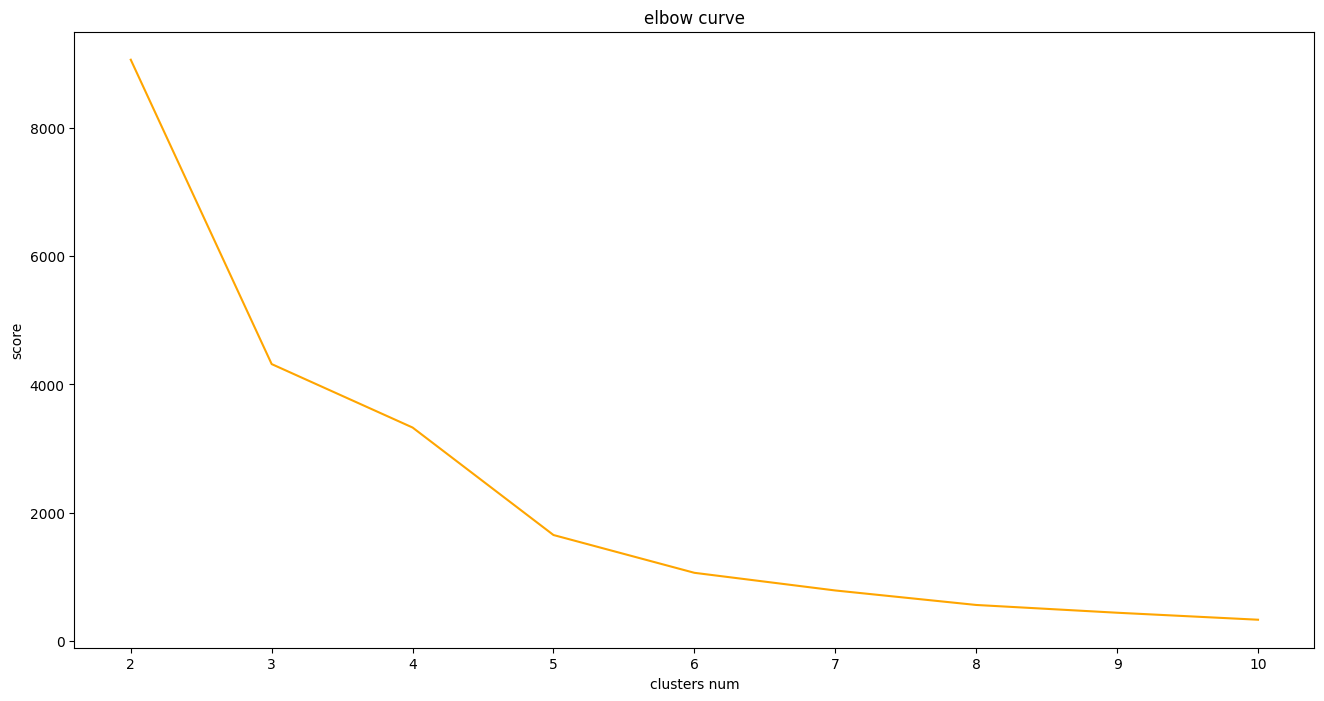

In [20]:
fig, ax = plt.subplots(figsize = (16, 8))
ax.plot(n_cluster, scores, color = 'orange')

plt.xlabel('clusters num')
plt.ylabel('score')
plt.title('elbow curve')

In [21]:
kmeans = KMeans(n_clusters=3).fit(df_c[cols])
df_c['kmeans'] = pd.Series(kmeans.predict(df_c[cols]))
df_c.head()

,timestamp,target,anomaly,lag_1,lag_2,lag_3,rolling_15,rolling_30,rolling_45,rolling_60,minute,target_average,kmeans
3,2020-03-09 12:34:40,24.9110,0.0,24.9055,24.9038,24.9122,24.908125,24.908125,24.908125,24.908125,34,24.923513,2.0
4,2020-03-09 12:34:41,24.9110,0.0,24.9110,24.9055,24.9038,24.908700,24.908700,24.908700,24.908700,34,24.923513,2.0
5,2020-03-09 12:34:42,24.9225,0.0,24.9110,24.9110,24.9055,24.911000,24.911000,24.911000,24.911000,34,24.923513,2.0
6,2020-03-09 12:34:43,24.9225,0.0,24.9225,24.9110,24.9110,24.912643,24.912643,24.912643,24.912643,34,24.923513,2.0
7,2020-03-09 12:34:44,24.9233,0.0,24.9225,24.9225,24.9110,24.913975,24.913975,24.913975,24.913975,34,24.923513,2.0


In [22]:
df_c['kmeans'].unique()

array([ 2.,  0.,  1., nan])

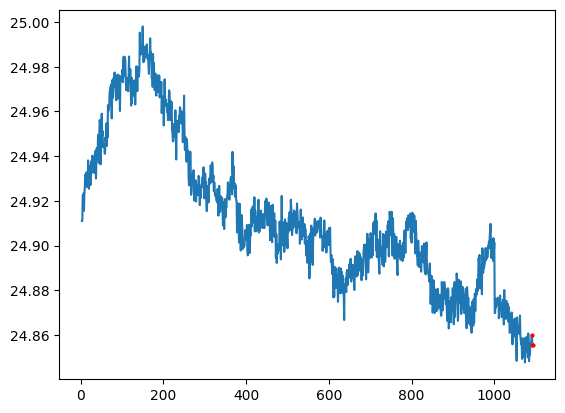

In [44]:
plt.plot(df_c['target'])
plt.plot(df_c.loc[df_c['kmeans'].isna(), 'target'], "ro", markersize=2)

In [24]:
db = DBSCAN(eps=0.5, min_samples=3).fit(df_c[cols])
df_c['dbscan'] = pd.Series(db.fit_predict(df_c[cols]))
df_c.head()

,timestamp,target,anomaly,lag_1,lag_2,lag_3,rolling_15,rolling_30,rolling_45,rolling_60,minute,target_average,kmeans,dbscan
3,2020-03-09 12:34:40,24.9110,0.0,24.9055,24.9038,24.9122,24.908125,24.908125,24.908125,24.908125,34,24.923513,2.0,0.0
4,2020-03-09 12:34:41,24.9110,0.0,24.9110,24.9055,24.9038,24.908700,24.908700,24.908700,24.908700,34,24.923513,2.0,0.0
5,2020-03-09 12:34:42,24.9225,0.0,24.9110,24.9110,24.9055,24.911000,24.911000,24.911000,24.911000,34,24.923513,2.0,0.0
6,2020-03-09 12:34:43,24.9225,0.0,24.9225,24.9110,24.9110,24.912643,24.912643,24.912643,24.912643,34,24.923513,2.0,0.0
7,2020-03-09 12:34:44,24.9233,0.0,24.9225,24.9225,24.9110,24.913975,24.913975,24.913975,24.913975,34,24.923513,2.0,0.0


In [25]:
df_c['dbscan'].unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., nan])

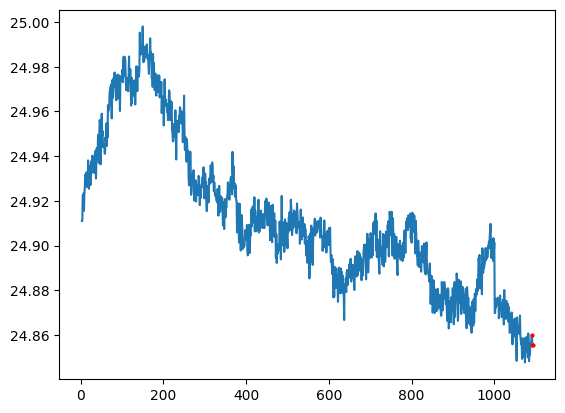

In [45]:
plt.plot(df_c['target'])
plt.plot(df_c.loc[df_c['dbscan'].isna(), 'target'], "ro", markersize=2)

In [27]:
df_c[['kmeans_anomaly', 'dbscan_anomaly']] = 0
df_c.loc[df_c['dbscan'].isna(), 'kmeans_anomaly'] = 1
df_c.loc[df_c['dbscan'].isna(), 'dbscan_anomaly'] = 1

In [28]:
df_c[df_c['kmeans_anomaly'] == 1]

,timestamp,target,anomaly,lag_1,lag_2,lag_3,rolling_15,rolling_30,rolling_45,rolling_60,minute,target_average,kmeans,dbscan,kmeans_anomaly,dbscan_anomaly
1091,2020-03-09 12:54:35,24.8600,0.0,24.8596,24.8565,24.8560,24.856007,24.855817,24.857869,24.860095,54,24.856676,NaN,NaN,1,1
1092,2020-03-09 12:54:36,24.8553,0.0,24.8600,24.8596,24.8565,24.855767,24.855370,24.857618,24.859863,54,24.856676,NaN,NaN,1,1
1093,2020-03-09 12:54:37,24.8555,0.0,24.8553,24.8600,24.8596,24.855960,24.855243,24.857400,24.859557,54,24.856676,NaN,NaN,1,1


In [29]:
df_c[df_c['dbscan_anomaly'] == 1]

,timestamp,target,anomaly,lag_1,lag_2,lag_3,rolling_15,rolling_30,rolling_45,rolling_60,minute,target_average,kmeans,dbscan,kmeans_anomaly,dbscan_anomaly
1091,2020-03-09 12:54:35,24.8600,0.0,24.8596,24.8565,24.8560,24.856007,24.855817,24.857869,24.860095,54,24.856676,NaN,NaN,1,1
1092,2020-03-09 12:54:36,24.8553,0.0,24.8600,24.8596,24.8565,24.855767,24.855370,24.857618,24.859863,54,24.856676,NaN,NaN,1,1
1093,2020-03-09 12:54:37,24.8555,0.0,24.8553,24.8600,24.8596,24.855960,24.855243,24.857400,24.859557,54,24.856676,NaN,NaN,1,1


In [30]:
cm_cluster = cm(df_c['anomaly'], df_c['dbscan_anomaly'])
cm_cluster

array([[683,   3],
       [405,   0]])

In [32]:
from sklearn.ensemble import IsolationForest
df_c.columns

Index(['timestamp', 'target', 'anomaly', 'lag_1', 'lag_2', 'lag_3',
       'rolling_15', 'rolling_30', 'rolling_45', 'rolling_60', 'minute',
       'target_average', 'kmeans', 'dbscan', 'kmeans_anomaly',
       'dbscan_anomaly'],
      dtype='object')

In [33]:
df_i = df_c[['timestamp', 'target', 'anomaly', 'lag_1', 'lag_2', 'lag_3', 'rolling_15',
             'rolling_30', 'rolling_45','rolling_60', 'minute', 'target_average']]
df_i

,timestamp,target,anomaly,lag_1,lag_2,lag_3,rolling_15,rolling_30,rolling_45,rolling_60,minute,target_average
3,2020-03-09 12:34:40,24.9110,0.0,24.9055,24.9038,24.9122,24.908125,24.908125,24.908125,24.908125,34,24.923513
4,2020-03-09 12:34:41,24.9110,0.0,24.9110,24.9055,24.9038,24.908700,24.908700,24.908700,24.908700,34,24.923513
5,2020-03-09 12:34:42,24.9225,0.0,24.9110,24.9110,24.9055,24.911000,24.911000,24.911000,24.911000,34,24.923513
6,2020-03-09 12:34:43,24.9225,0.0,24.9225,24.9110,24.9110,24.912643,24.912643,24.912643,24.912643,34,24.923513
7,2020-03-09 12:34:44,24.9233,0.0,24.9225,24.9225,24.9110,24.913975,24.913975,24.913975,24.913975,34,24.923513
...,...,...,...,...,...,...,...,...,...,...,...,...
1089,2020-03-09 12:54:33,24.8565,0.0,24.8560,24.8562,24.8511,24.855627,24.855880,24.858184,24.860460,54,24.856676
1090,2020-03-09 12:54:34,24.8596,0.0,24.8565,24.8560,24.8562,24.855847,24.855853,24.858020,24.860248,54,24.856676
1091,2020-03-09 12:54:35,24.8600,0.0,24.8596,24.8565,24.8560,24.856007,24.855817,24.857869,24.860095,54,24.856676
1092,2020-03-09 12:54:36,24.8553,0.0,24.8600,24.8596,24.8565,24.855767,24.855370,24.857618,24.859863,54,24.856676


In [34]:
model = IsolationForest(
    random_state=2024,
    contamination=0.005,
    n_estimators=200,
    max_samples=0.7
)

model.fit(df_i[cols])

IsolationForest(contamination=0.005, max_samples=0.7, n_estimators=200,
                random_state=2024)

In [35]:
df_i['outlier'] = pd.Series(model.predict(df_i[cols])).apply(lambda x: 1 if x == -1 else 0)
score = model.decision_function(df_i[cols])
df_i['Score'] = score
df_i.head()

<ipython-input-35-ee8c1f10f02e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_i['outlier'] = pd.Series(model.predict(df_i[cols])).apply(lambda x: 1 if x == -1 else 0)
<ipython-input-35-ee8c1f10f02e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_i['Score'] = score


,timestamp,target,anomaly,lag_1,lag_2,lag_3,rolling_15,rolling_30,rolling_45,rolling_60,minute,target_average,outlier,Score
3,2020-03-09 12:34:40,24.9110,0.0,24.9055,24.9038,24.9122,24.908125,24.908125,24.908125,24.908125,34,24.923513,0.0,0.073685
4,2020-03-09 12:34:41,24.9110,0.0,24.9110,24.9055,24.9038,24.908700,24.908700,24.908700,24.908700,34,24.923513,0.0,0.080158
5,2020-03-09 12:34:42,24.9225,0.0,24.9110,24.9110,24.9055,24.911000,24.911000,24.911000,24.911000,34,24.923513,0.0,0.067217
6,2020-03-09 12:34:43,24.9225,0.0,24.9225,24.9110,24.9110,24.912643,24.912643,24.912643,24.912643,34,24.923513,0.0,0.078377
7,2020-03-09 12:34:44,24.9233,0.0,24.9225,24.9225,24.9110,24.913975,24.913975,24.913975,24.913975,34,24.923513,0.0,0.077634


In [36]:
df_i['outlier'].unique()

array([ 0.,  1., nan])

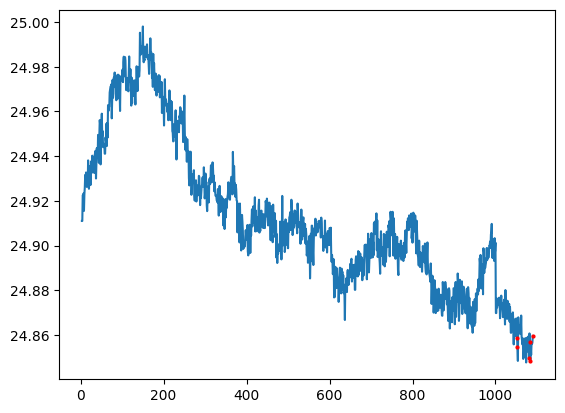

In [46]:
plt.plot(df_i['target'])
plt.plot(df_i.loc[df_i['outlier'] == 1, 'target'], "ro", markersize=2)

In [38]:
df_i = df_i.dropna()

In [39]:
cm_isol = cm(df_i['anomaly'], df_i['outlier'])
cm_isol

array([[677,   6],
       [405,   0]])

In [40]:
cm_stat, cm_cluster, cm_isol

(array([[686,   3],
        [405,   0]]),
 array([[683,   3],
        [405,   0]]),
 array([[677,   6],
        [405,   0]]))

In [41]:
result = pd.DataFrame({'model': ['cm_stat', 'cm_cluster', 'cm_isol'],
                       'cm': [cm_stat, cm_cluster, cm_isol]})
result

,model,cm
0,cm_stat,"[[686, 3], [405, 0]]"
1,cm_cluster,"[[683, 3], [405, 0]]"
2,cm_isol,"[[677, 6], [405, 0]]"
